In [1]:
from Game import *
from Game.minimax import *

Version:  0.2.42


## Nim

In [3]:
def initial_state(): 
    """ returns  - The initial state of the game"""
    return 21

def valid_moves(state,player):
    """returns  - a list of the valid moves for the state and player"""

    if state==2:
        return [1,2]
    elif state==1:
        return [1]
    else:
        return [1,2,3]

def show_state(state):
    """prints or shows the current state"""
    print("There are",state,"sticks.")

def update_state(state,player,move):
    """returns  - the new state after the move for the player"""

    new_state=state-move

    return new_state


def win_status(state,player):
    """    returns  - 'win'  if the state is a winning state for the player, 
               'lose' if the state is a losing state for the player,
               'stalemate' for a stalemate
               None otherwise
    """

    if state==0:
        return 'lose'

    if state==1:
        return 'win'


    return None
    


## Agents

In [4]:
def random_move(state,player):    
    moves=valid_moves(state,player)
    return random.choice(moves)

random_agent=Agent(random_move)

def human_move(state,player):
    print("Player ", player)
    valid_move=False
    while not valid_move:
        move=int(input('What is your move? '))

        if move in valid_moves(state,player):
            valid_move=True
        else:
            print("Illegal move.")

    return move

human_agent=Agent(human_move)

In [5]:
def minimax_move(state,player):
    values,moves=minimax_values(state,player,display=False)
    return top_choice(moves,values)


minimax_agent=Agent(minimax_move)

In [11]:
def Q_move(state,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ
    
    if state not in Q:
        actions=valid_moves(state,player)
        Q[state]=Table()
        for action in actions:
            Q[state][action]=0  # initial value of table
    
    if learning:
        if random.random()<ϵ:  # take a random move occasionally to explore the environment
            move=random_move(state,player)
        else:
            move=top_choice(Q[state])
    else:
        move=top_choice(Q[state])
    
    if not last_action is None:  # not the first move
        reward=0
        
        # learn
        if learning:
            Q[last_state][last_action]+=α*(reward +
                        γ*max([Q[state][a] for a in Q[state]]) - Q[last_state][last_action])
    
    return move


def Q_after(status,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ

    if status=='lose':
        reward=-1
    elif status=='win':
        reward=1
    elif status=='stalemate':
        reward=.5 # value stalemate a little closer to a win
    else:
        reward=0
    
    
    if learning:
        Q[last_state][last_action]+=α*(reward - Q[last_state][last_action])
        


In [10]:
def skittles_move(state,player,info):
    S=info.S
    last_state=info.last_state
    last_action=info.last_action
    
    # make/adjust the table

    if state not in S:
        # add a row to the table for each move
        S[state]=Table()
        moves=valid_moves(state,player)
        for action in moves:
            S[state][action]=3  # number of skittles/beads for each move
    
    move=weighted_choice(S[state])

    if move is None:  # there are no skittles in this row
        if last_state:
            S[last_state][last_action]=S[last_state][last_action]-1
            if S[last_state][last_action]<0:
                S[last_state][last_action]=0

        move=random_move(state,player)

    
    return move

def skittles_after(status,player,info):
    S=info.S
    last_state=info.last_state
    last_action=info.last_action

    if status=='lose':
        if last_state:
            S[last_state][last_action]=S[last_state][last_action]-1
            if S[last_state][last_action]<0:
                S[last_state][last_action]=0
                
    # does this double-count the learning if you lose on your own turn        
    

In [7]:
skittles_agent=Agent(skittles_move)
skittles_agent.S=Table()
skittles_agent.post=skittles_after

In [12]:
Q_agent=Agent(Q_move)
Q_agent.post=Q_after
Q_agent.Q=Table()  # makes an empty table
Q_agent.learning=True

Q_agent.α=0.4  # learning rate
Q_agent.ϵ=0.5  # how often to take a random move
Q_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

In [13]:
def perfect_move(state,player):
    move=(state-1)%4

    if move==0:  # bad state
        move=1

    return move

perfect_agent=Agent(perfect_move)

In [14]:
g=Game(number_of_games=100)
g.display=False
g.run(perfect_agent,Q_agent)
g.report()  

Total number of games:  100
Winning 86.00 percent
Losing 14.00 percent
Tie 0.00 percent


In [15]:
SaveTable(Q_agent.Q,'nim Q.json')

## Progress

In [17]:
%matplotlib inline
from matplotlib.pyplot import figure,plot,grid,legend,xlabel,ylabel,title
from tqdm import tqdm

In [45]:
agent1=perfect_agent
agent2=Q_agent
agent2.Q=Table()

In [46]:
S=Storage()
one,two,ties,N=0,0,0,0

In [47]:
N_test=100
N_train=10

In [48]:
for i in tqdm(range(150)):
    Q_agent.learning=True
    g=Game(number_of_games=N_train)
    g.display=False
    result=g.run(agent1,agent2)

    
    Q_agent.learning=False
    g=Game(number_of_games=N_test)
    g.display=False
    result=g.run(agent1,agent2)
    one,two,ties,N=one+result.count(1),two+result.count(2),ties+result.count(0),N+len(result)
    
    S+=one/N*100,two/N*100,ties/N*100,(i+1)*N_train

100%|█████████████████████████████████████████████████████████████| 150/150 [00:05<00:00, 26.18it/s]


In [49]:
y1,y2,y0,x=S.arrays()

Text(0, 0.5, 'Percent')

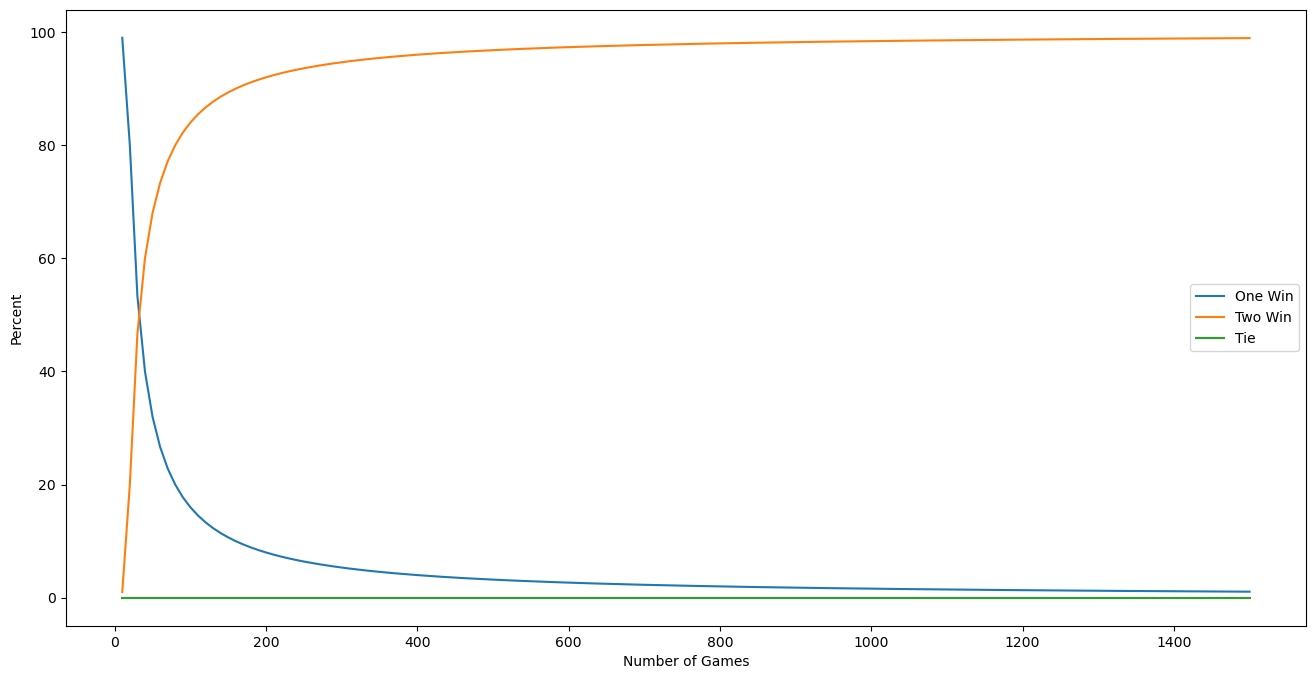

In [50]:
figure(figsize=(16,8))
plot(x,y1,label='One Win')
plot(x,y2,label='Two Win')
plot(x,y0,label='Tie')
legend()
xlabel('Number of Games')
ylabel('Percent')

In [52]:
g=Game(number_of_games=100)
g.display=False
g.run(perfect_agent,Q_agent)
g.report()  

Total number of games:  100
Winning 0.00 percent
Losing 100.00 percent
Tie 0.00 percent


In [53]:
Q_agent.Q

{20: {1: -0.6560999999999996, 2: -0.6560999999999996, 3: 0.6560999999999996},
 17: {1: -0.7289999999999996, 2: -0.7289999999999996, 3: -0.7289999999999996},
 13: {1: -0.8099999999999997, 2: -0.8099999999999997, 3: -0.8099999999999997},
 9: {1: -0.8999999999999998, 2: -0.8999999999999998, 3: -0.8999999999999998},
 5: {1: -0.9999999999999999, 2: -0.9999999999999999, 3: -0.9999999999999999},
 16: {1: -0.7289999999999996, 2: -0.7289999999999996, 3: 0.7289999999999996},
 12: {1: -0.8099999999999997, 2: -0.8099999999999997, 3: 0.8099999999999997},
 8: {1: -0.8999999999999998, 2: -0.8999999999999998, 3: 0.8999999999999998},
 4: {1: -0.9999999999376327, 2: -0.9999999998960544, 3: 0.9999999999999999}}

In [54]:
SaveTable(Q_agent.Q,'nim Q.json')